In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
# dummy values for ocean_proximity
data = pd.get_dummies(data,drop_first=True)
data.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,1,0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
longitude                     20640 non-null float64
latitude                      20640 non-null float64
housing_median_age            20640 non-null float64
total_rooms                   20640 non-null float64
total_bedrooms                20640 non-null float64
population                    20640 non-null float64
households                    20640 non-null float64
median_income                 20640 non-null float64
median_house_value            20640 non-null float64
ocean_proximity_INLAND        20640 non-null uint8
ocean_proximity_ISLAND        20640 non-null uint8
ocean_proximity_NEAR BAY      20640 non-null uint8
ocean_proximity_NEAR OCEAN    20640 non-null uint8
dtypes: float64(9), uint8(4)
memory usage: 1.5 MB


In [17]:
data['total_bedrooms'].isnull().any()

False

In [16]:
# Removing null values in 'total_bedrooms' with median value
median_bedrooms = data['total_bedrooms'].median()
data['total_bedrooms'].fillna(median_bedrooms,inplace=True)
data['total_bedrooms'].isnull().any()

False

C:\Users\aravi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\aravi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\aravi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\aravi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWar

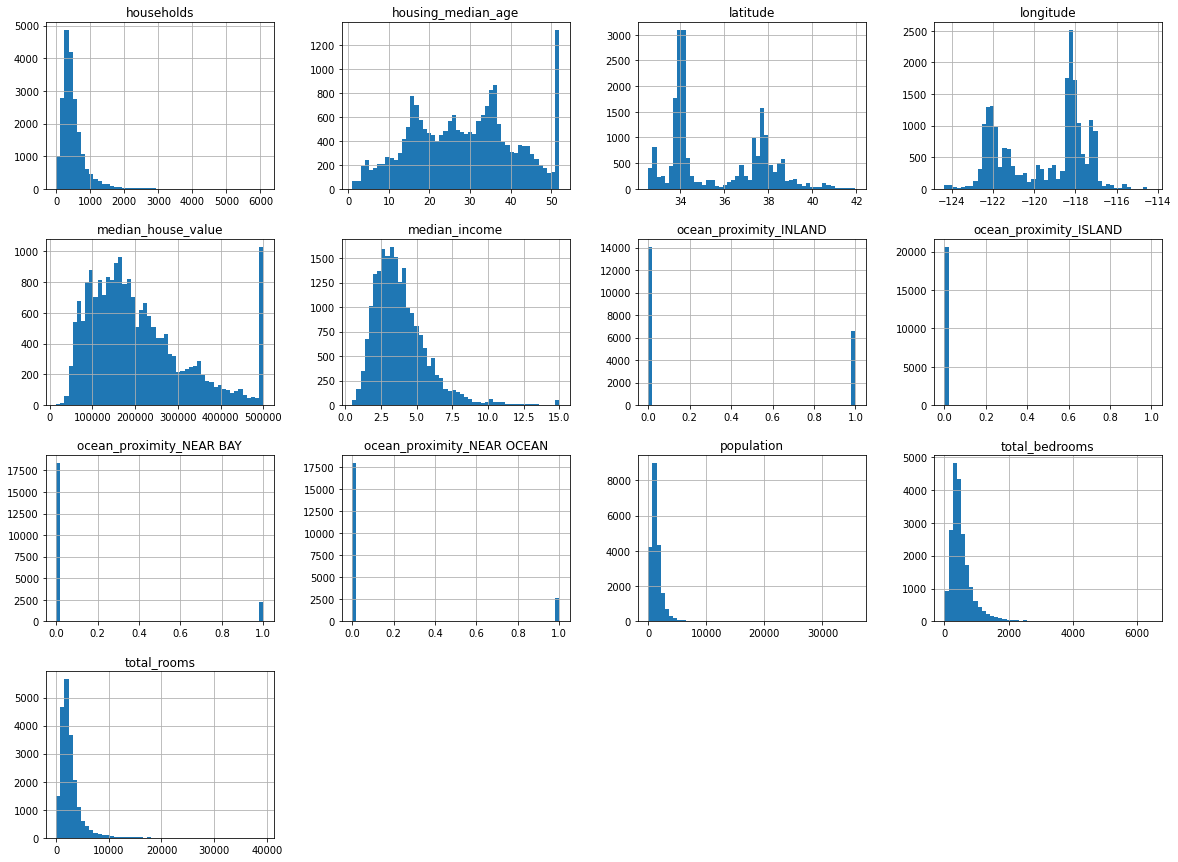

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

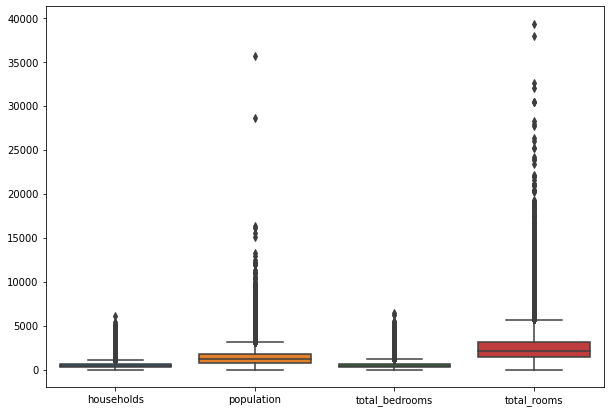

In [19]:
# Outliers
import seaborn as sns
columns = ['households','population','total_bedrooms','total_rooms']
plt.figure(figsize=(10,7))
sns.boxplot(data=data[columns])


In [22]:
# calculating number of outliers in data. (ignore that of ocean_proximity)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3-Q1
High = (Q3) + 1.5*IQR
Low = (Q1) - 1.5*IQR

((data < Low) | (data > High)).sum()

longitude                        0
latitude                         0
housing_median_age               0
total_rooms                   1287
total_bedrooms                1306
population                    1196
households                    1220
median_income                  681
median_house_value            1071
ocean_proximity_INLAND           0
ocean_proximity_ISLAND           5
ocean_proximity_NEAR BAY      2290
ocean_proximity_NEAR OCEAN    2658
dtype: int64

In [23]:
corr = data.corr()
corr.style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
longitude,1,-0.924664,-0.108197,0.044568,0.0691197,0.0997732,0.0553101,-0.0151759,-0.0459666,-0.0555747,0.0094455,-0.474489,0.0455088
latitude,-0.924664,1,0.0111727,-0.0360996,-0.0664839,-0.108785,-0.0710354,-0.0798091,-0.14416,0.351166,-0.0165716,0.358771,-0.160818
housing_median_age,-0.108197,0.0111727,1,-0.361262,-0.319026,-0.296244,-0.302916,-0.119034,0.105623,-0.236645,0.0170198,0.255172,0.0216216
total_rooms,0.044568,-0.0360996,-0.361262,1,0.927058,0.857126,0.918484,0.19805,0.134153,0.0256243,-0.00757177,-0.0230224,-0.00917515
total_bedrooms,0.0691197,-0.0664839,-0.319026,0.927058,1,0.873535,0.974366,-0.00761687,0.0494569,-0.0061581,-0.00432187,-0.0196667,0.00055678
population,0.0997732,-0.108785,-0.296244,0.857126,0.873535,1,0.907222,0.00483435,-0.0246497,-0.0207321,-0.0104121,-0.0608802,-0.0242637
households,0.0553101,-0.0710354,-0.302916,0.918484,0.974366,0.907222,1,0.0130331,0.0658427,-0.0394025,-0.009077,-0.0100933,0.00171443
median_income,-0.0151759,-0.0798091,-0.119034,0.19805,-0.00761687,0.00483435,0.0130331,1,0.688075,-0.237496,-0.00922817,0.0561968,0.0273436
median_house_value,-0.0459666,-0.14416,0.105623,0.134153,0.0494569,-0.0246497,0.0658427,0.688075,1,-0.484859,0.0234161,0.160284,0.141862
ocean_proximity_INLAND,-0.0555747,0.351166,-0.236645,0.0256243,-0.0061581,-0.0207321,-0.0394025,-0.237496,-0.484859,1,-0.0106144,-0.240887,-0.262163


In [29]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values
print(X.shape,y.shape)

(20640, 12) (20640,)


In [34]:
# test train split
from sklearn.model_selection import train_test_split
X_train_full,X_test,y_train_full,y_test = train_test_split(X,y,random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=0)
print(X_train_full.shape,'  ',X_test.shape)
print(y_train_full.shape,'  ',y_test.shape)
print(X_train.shape,'  ',X_valid.shape)
print(y_train.shape,'  ',y_valid.shape)

(15480, 12)    (5160, 12)
(15480,)    (5160,)
(11610, 12)    (3870, 12)
(11610,)    (3870,)


In [35]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


In [36]:
X_train.shape[1:]

(12,)

In [42]:
#model building
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1)
])


In [43]:
# compile the model
model.compile(loss="mse", optimizer="adam",metrics='accuracy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 30)                390       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 761
Trainable params: 761
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
363/363 [==============================] - 0s 1ms/step - loss: 0.1335 - accuracy: 0.8711 - val_loss: 0.0888 - val_accuracy: 0.8884
Epoch 2/30
363/363 [==============================] - 0s 876us/step - loss: 0.0875 - accuracy: 0.8833 - val_loss: 0.0797 - val_accuracy: 0.8946
Epoch 3/30
363/363 [==============================] - 0s 863us/step - loss: 0.0780 - accuracy: 0.8973 - val_loss: 0.0713 - val_accuracy: 0.9085
Epoch 4/30
363/363 [==============================] - 0s 867us/step - loss: 0.0706 - accuracy: 0.9069 - val_loss: 0.0646 - val_accuracy: 0.9173
Epoch 5/30
363/363 [==============================] - 0s 884us/step - loss: 0.0636 - accuracy: 0.9162 - val_loss: 0.0598 - val_accuracy: 0.9264
Epoch 6/30
363/363 [==============================] - 0s 919us/step - loss: 0.0567 - accuracy: 0.9230 - val_loss: 0.0540 - val_accuracy: 0.9328
Epoch 7/30
363/363 [==============================] - 2s 6ms/step - loss: 0.0517 - accuracy: 0.9290 - val_loss: 0.0488 - val_accuracy: 0.9

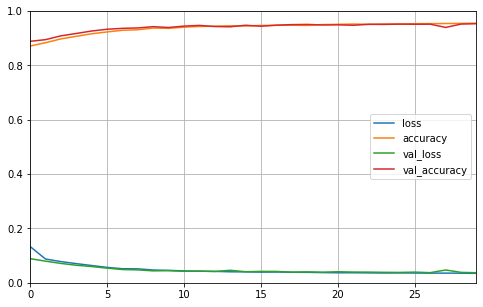

In [45]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()